In [1]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

import sys
sys.path.append(os.getenv("PROJECT_PATH"))

from inference import get_model
import supervision as sv

ROBOFLOW_API_KEY = os.getenv("ROBOFLOW_API_KEY")

PLAYER_DETECTION_MODEL_ID = 'football-players-detection-3zvbc/2'
PLAYER_DETECTION_MODEL = get_model(PLAYER_DETECTION_MODEL_ID, ROBOFLOW_API_KEY)

FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

SOURCE_VIDEO_PATH = "../data/videos/testvid.mp4"

[07/08/25 15:45:45] WARNING  Your inference package version 0.44.1 is out of date! Please upgrade to ]8;id=204798;file://c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=82040;file://c:\Users\pedro\AppData\Local\Programs\Python\Python310\lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.51.2 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does

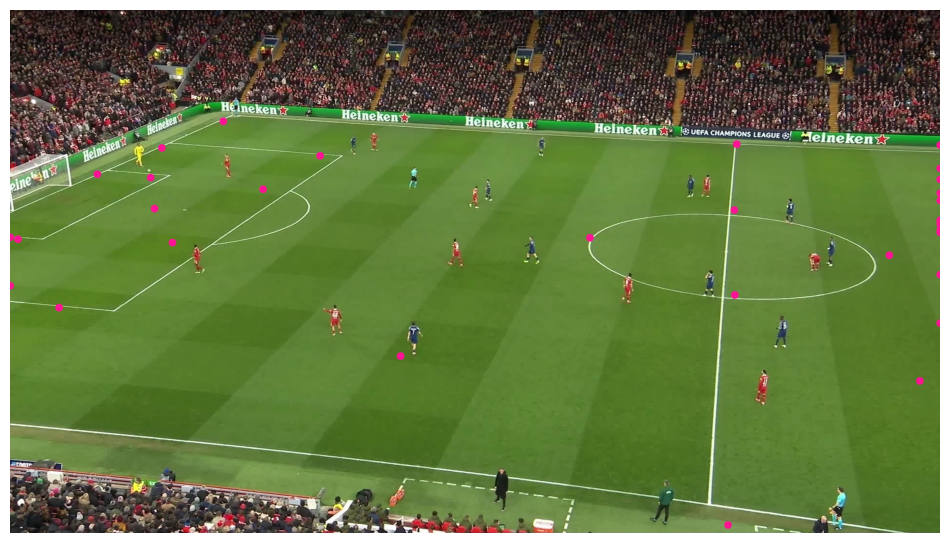

In [2]:
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

sv.plot_image(annotated_frame)

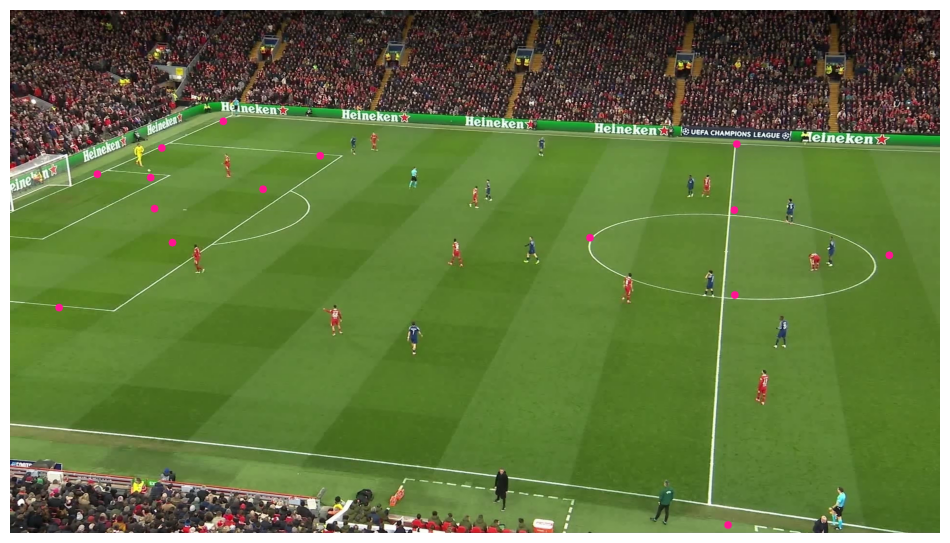

In [3]:
import numpy as np

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

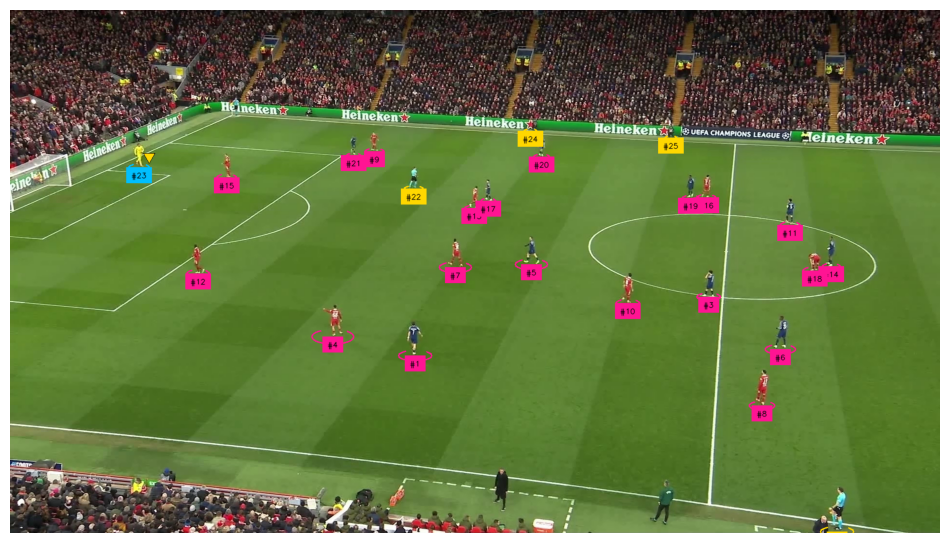

In [4]:
import supervision as sv

BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

tracker = sv.ByteTrack()
tracker.reset()

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)
all_detections.class_id -= 1
all_detections = tracker.update_with_detections(detections=all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id
    in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=all_detections,
    labels=labels)
annotated_frame = triangle_annotator.annotate(
    scene=annotated_frame,
    detections=ball_detections)

sv.plot_image(annotated_frame)